# 🛣️ Road Damage Detection - Training dengan YOLOv8

**Notebook ini untuk tugas Deep Learning**

Proyek ini menggunakan **Transfer Learning** dengan model YOLOv8 yang di-train ulang pada dataset Road Damage Detection Challenge 2022.

### Jenis Kerusakan yang Dideteksi:
1. **Longitudinal Crack** - Retak memanjang
2. **Transverse Crack** - Retak melintang
3. **Alligator Crack** - Retak buaya/fatigue
4. **Potholes** - Lubang jalan

---
**Referensi:** [oracl4/RoadDamageDetection](https://github.com/oracl4/RoadDamageDetection)

## 📌 Step 1: Setup Environment & Check GPU

In [ ]:
# Cek GPU yang tersedia di Colab
!nvidia-smi

Tue Dec  2 12:29:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install library yang dibutuhkan
!pip install ultralytics -q
!pip install roboflow -q  # Optional, untuk download dataset alternatif

print("✅ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.4 MB/s eta 0:00:00
✅ Installation complete!


In [ ]:
# Import libraries
import os
import shutil
import random
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm
import yaml

from ultralytics import YOLO
import torch

# Cek CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## 📌 Step 2: Mount Google Drive (untuk menyimpan model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Buat folder untuk menyimpan hasil training
SAVE_DIR = '/content/drive/MyDrive/RoadDamageDetection'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"✅ Save directory: {SAVE_DIR}")

Mounted at /content/drive
✅ Save directory: /content/drive/MyDrive/RoadDamageDetection


## 📌 Step 3: Download Dataset RDD2022

Dataset dari [Crowdsensing-based Road Damage Detection Challenge 2022](https://github.com/sekilab/RoadDamageDetector)

In [ ]:
# Download dataset RDD2022
# Dataset ~4GB

%cd /content

# Download dari official source
!wget -q --show-progress https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_Japan.zip
!wget -q --show-progress https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_India.zip

print("\n✅ Download complete!")

/content
RDD2022_Japan.zip   100%[===================>]   1023M  33.9MB/s    in 35s     
RDD2022_India.zip   100%[===================>] 502.31M  28.6MB/s    in 21s     

✅ Download complete!


In [ ]:
# Extract dataset
!mkdir -p /content/dataset/RDD2022
!unzip -q RDD2022_Japan.zip -d /content/dataset/RDD2022/
!unzip -q RDD2022_India.zip -d /content/dataset/RDD2022/

# Cleanup zip files
!rm -f RDD2022_Japan.zip RDD2022_India.zip

print("✅ Extraction complete!")
!ls /content/dataset/RDD2022/

✅ Extraction complete!
India  Japan


## 📌 Step 4: Konversi Dataset (PascalVOC → YOLO Format)

Dataset RDD2022 menggunakan format PascalVOC (XML), perlu dikonversi ke format YOLO (TXT)

In [ ]:
# Class mapping untuk Road Damage Detection
CLASS_MAPPING = {
    'D00': 0,  # Longitudinal Crack
    'D10': 1,  # Transverse Crack
    'D20': 2,  # Alligator Crack
    'D40': 3,  # Pothole
}

CLASS_NAMES = ['Longitudinal_Crack', 'Transverse_Crack', 'Alligator_Crack', 'Pothole']

def convert_voc_to_yolo(xml_path, img_width, img_height):
    """
    Konversi annotation dari PascalVOC (XML) ke YOLO format
    YOLO format: class_id x_center y_center width height (normalized 0-1)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text

        # Skip jika class tidak ada di mapping
        if class_name not in CLASS_MAPPING:
            continue

        class_id = CLASS_MAPPING[class_name]

        # Get bounding box
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        # Convert to YOLO format (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        # Clamp values between 0 and 1
        x_center = max(0, min(1, x_center))
        y_center = max(0, min(1, y_center))
        width = max(0, min(1, width))
        height = max(0, min(1, height))

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

print("✅ Conversion functions defined!")

✅ Conversion functions defined!


In [ ]:
from PIL import Image

def prepare_dataset(countries, base_path, output_path, train_ratio=0.8):
    """
    Prepare dataset untuk training YOLO
    - Konversi annotations
    - Split train/val
    - Copy ke struktur folder YOLO
    """

    # Create output directories
    for split in ['train', 'val']:
        os.makedirs(f"{output_path}/images/{split}", exist_ok=True)
        os.makedirs(f"{output_path}/labels/{split}", exist_ok=True)

    all_images = []

    for country in countries:
        country_path = f"{base_path}/{country}/train"
        images_path = f"{country_path}/images"
        annotations_path = f"{country_path}/annotations/xmls"

        if not os.path.exists(images_path):
            print(f"⚠️ Path not found: {images_path}")
            continue

        print(f"\n📂 Processing {country}...")

        # Get all images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for img_file in tqdm(image_files, desc=f"Converting {country}"):
            img_name = os.path.splitext(img_file)[0]
            xml_file = f"{annotations_path}/{img_name}.xml"
            img_path = f"{images_path}/{img_file}"

            # Skip jika tidak ada annotation
            if not os.path.exists(xml_file):
                continue

            try:
                # Get image dimensions
                with Image.open(img_path) as img:
                    img_width, img_height = img.size

                # Convert annotations
                yolo_annotations = convert_voc_to_yolo(xml_file, img_width, img_height)

                # Skip images without valid annotations (background images)
                if len(yolo_annotations) == 0:
                    continue

                all_images.append({
                    'img_path': img_path,
                    'img_name': f"{country}_{img_file}",
                    'annotations': yolo_annotations
                })

            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue

    # Shuffle and split
    random.seed(42)
    random.shuffle(all_images)

    split_idx = int(len(all_images) * train_ratio)
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]

    print(f"\n📊 Dataset Statistics:")
    print(f"   Total images with annotations: {len(all_images)}")
    print(f"   Training images: {len(train_images)}")
    print(f"   Validation images: {len(val_images)}")

    # Copy files to output
    for split, images in [('train', train_images), ('val', val_images)]:
        print(f"\n📁 Copying {split} files...")
        for item in tqdm(images, desc=f"Copying {split}"):
            # Copy image
            dst_img = f"{output_path}/images/{split}/{item['img_name']}"
            shutil.copy2(item['img_path'], dst_img)

            # Write labels
            label_name = os.path.splitext(item['img_name'])[0] + '.txt'
            dst_label = f"{output_path}/labels/{split}/{label_name}"
            with open(dst_label, 'w') as f:
                f.write('\n'.join(item['annotations']))

    print("\n✅ Dataset preparation complete!")
    return len(train_images), len(val_images)

In [ ]:
# Prepare dataset
COUNTRIES = ['Japan', 'India']  # Bisa tambah negara lain: 'Czech', 'Norway', etc.
BASE_PATH = '/content/dataset/RDD2022'
OUTPUT_PATH = '/content/dataset/rdd_yolo'

train_count, val_count = prepare_dataset(COUNTRIES, BASE_PATH, OUTPUT_PATH)


📂 Processing Japan...


Converting Japan: 100%|██████████| 10506/10506 [00:02<00:00, 3812.38it/s]



📂 Processing India...


Converting India: 100%|██████████| 7706/7706 [00:01<00:00, 5850.83it/s]



📊 Dataset Statistics:
   Total images with annotations: 11123
   Training images: 8898
   Validation images: 2225

📁 Copying train files...


Copying train: 100%|██████████| 8898/8898 [00:04<00:00, 2002.98it/s]



📁 Copying val files...


Copying val: 100%|██████████| 2225/2225 [00:00<00:00, 3832.03it/s]


✅ Dataset preparation complete!


In [ ]:
# Buat file konfigurasi YAML untuk YOLO
yaml_content = f"""# Road Damage Detection Dataset
# Dataset: CRDDC2022 (Japan + India)

path: {OUTPUT_PATH}
train: images/train
val: images/val

# Classes
names:
  0: Longitudinal_Crack
  1: Transverse_Crack
  2: Alligator_Crack
  3: Pothole

# Number of classes
nc: 4
"""

yaml_path = f"{OUTPUT_PATH}/rdd_dataset.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Dataset config saved to: {yaml_path}")
print("\n" + "="*50)
print(yaml_content)

✅ Dataset config saved to: /content/dataset/rdd_yolo/rdd_dataset.yaml

# Road Damage Detection Dataset
# Dataset: CRDDC2022 (Japan + India)

path: /content/dataset/rdd_yolo
train: images/train
val: images/val

# Classes
names:
  0: Longitudinal_Crack
  1: Transverse_Crack
  2: Alligator_Crack
  3: Pothole

# Number of classes
nc: 4



## 📌 Step 5: Visualisasi Sample Dataset

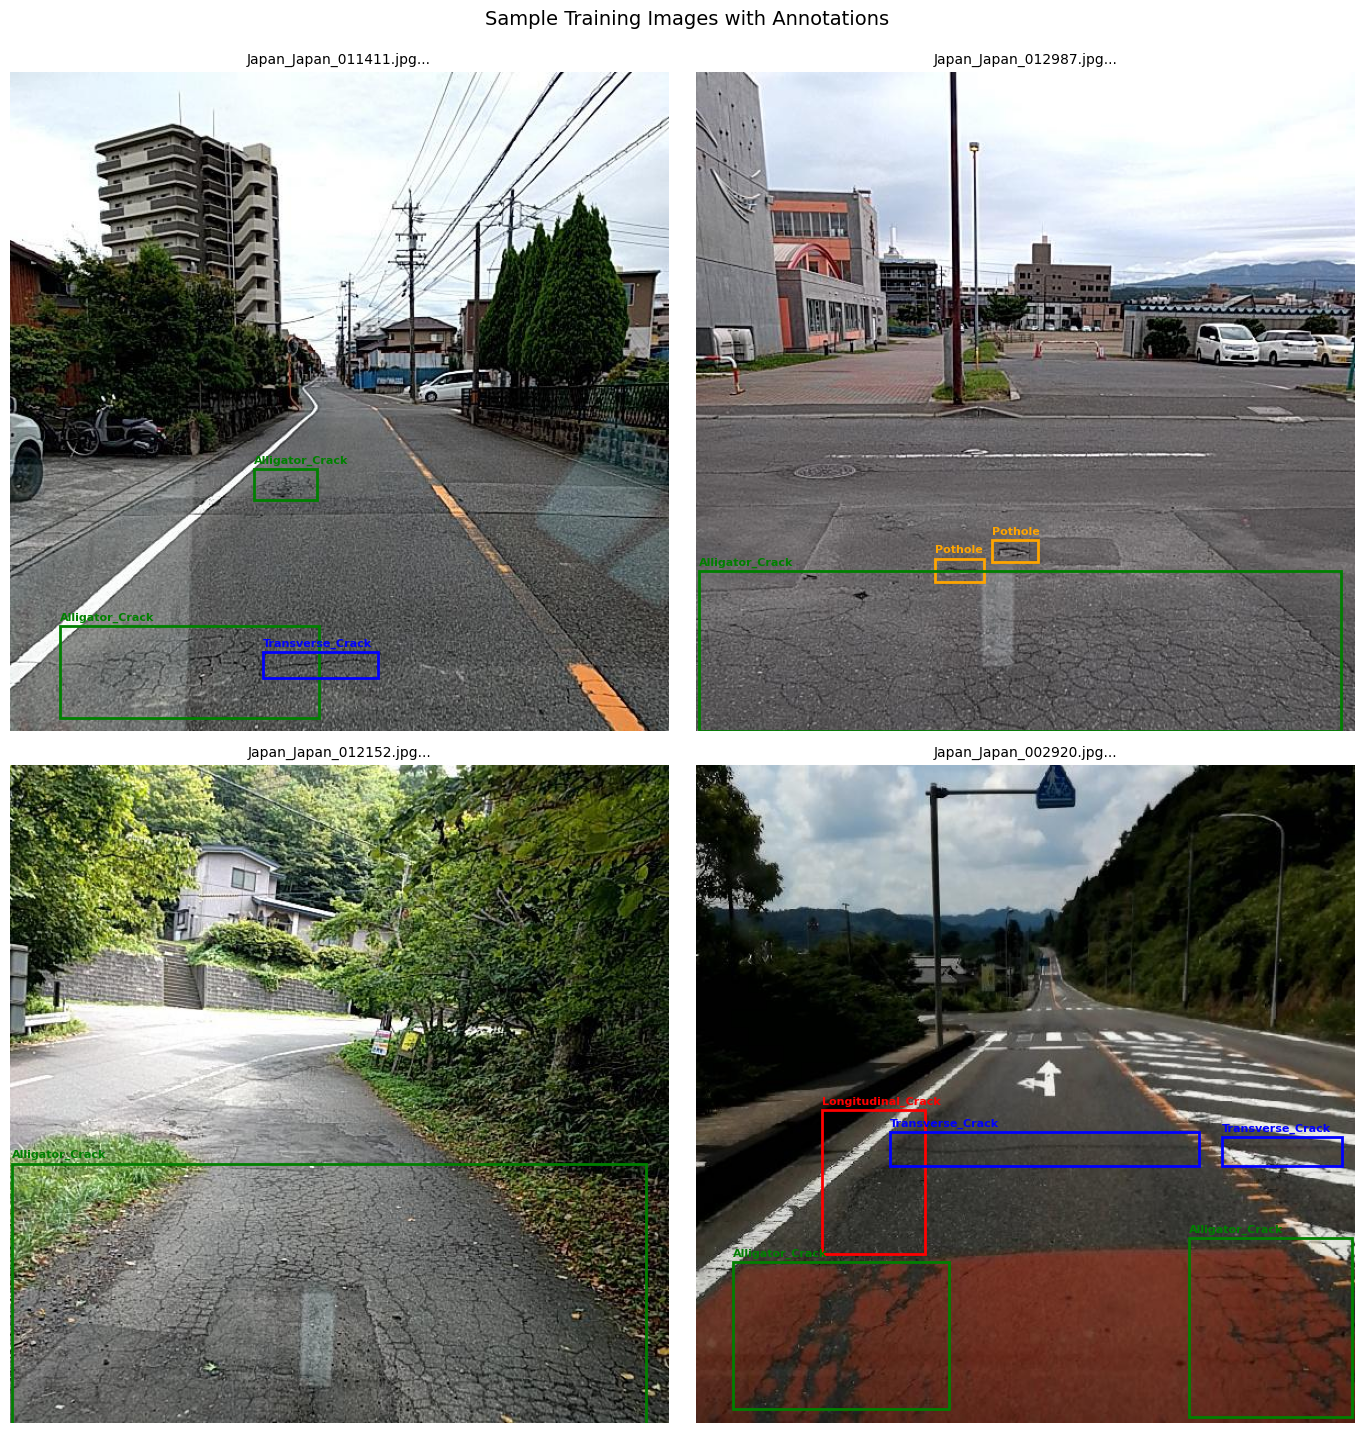

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def visualize_sample(dataset_path, num_samples=4):
    """Visualisasi beberapa sample dari dataset"""

    images_path = f"{dataset_path}/images/train"
    labels_path = f"{dataset_path}/labels/train"

    image_files = os.listdir(images_path)[:num_samples]

    colors = ['red', 'blue', 'green', 'orange']

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()

    for idx, img_file in enumerate(image_files):
        img_path = f"{images_path}/{img_file}"
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = f"{labels_path}/{label_file}"

        # Load image
        img = Image.open(img_path)
        img_width, img_height = img.size

        axes[idx].imshow(img)
        axes[idx].set_title(img_file[:30] + '...', fontsize=10)
        axes[idx].axis('off')

        # Load and draw annotations
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])

                        # Convert to pixel coordinates
                        x1 = (x_center - width/2) * img_width
                        y1 = (y_center - height/2) * img_height
                        w = width * img_width
                        h = height * img_height

                        # Draw rectangle
                        rect = patches.Rectangle(
                            (x1, y1), w, h,
                            linewidth=2,
                            edgecolor=colors[class_id],
                            facecolor='none'
                        )
                        axes[idx].add_patch(rect)
                        axes[idx].text(
                            x1, y1-5,
                            CLASS_NAMES[class_id],
                            color=colors[class_id],
                            fontsize=8,
                            fontweight='bold'
                        )

    plt.tight_layout()
    plt.suptitle('Sample Training Images with Annotations', fontsize=14, y=1.02)
    plt.show()

visualize_sample(OUTPUT_PATH)

## 📌 Step 6: Training YOLOv8 🚀

Ini adalah bagian **Transfer Learning** - kita menggunakan model YOLOv8 yang sudah pre-trained pada dataset COCO, lalu di-fine-tune pada dataset Road Damage Detection.

In [ ]:
# Load pretrained YOLOv8 model
# Pilihan model: yolov8n (nano), yolov8s (small), yolov8m (medium), yolov8l (large), yolov8x (extra large)


model = YOLO('yolov8s.pt')  # Download pretrained weights
print("✅ Model loaded!")

✅ Model loaded!


In [ ]:
# ⚡ TRAINING CONFIG
# Sesuaikan parameter sesuai kebutuhan

EPOCHS = 50           # Jumlah epoch (untuk demo bisa 10-20, untuk hasil bagus 50-100)
BATCH_SIZE = 16       # Batch size (kurangi jika Out of Memory)
IMG_SIZE = 640        # Image size
PATIENCE = 10         # Early stopping patience

# Start training
results = model.train(
    data=yaml_path,           # Path ke dataset config
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    save=True,
    save_period=10,           # Save checkpoint setiap 10 epoch
    device=0,                 # GPU
    workers=2,
    project='/content/runs/detect',
    name='road_damage_yolov8s',
    exist_ok=True,
    pretrained=True,          # Use pretrained weights (Transfer Learning)
    optimizer='auto',
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,               # Generate training plots
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/rdd_yolo/rdd_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_damage_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=

## 📌 Step 7: Evaluasi Model

In [ ]:
# Evaluasi pada validation set
metrics = model.val()

print("\n" + "="*50)
print("📊 EVALUATION RESULTS")
print("="*50)
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1807.8±614.6 MB/s, size: 70.6 KB)
val: Scanning /content/dataset/rdd_yolo/labels/val.cache... 2225 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2225/2225 3.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 140/140 4.1it/s 33.8s
                   all       2225       4732      0.592      0.499      0.537      0.243
    Longitudinal_Crack        823       1194      0.559      0.451      0.487      0.225
      Transverse_Crack        439        765      0.516      0.427      0.447      0.174
       Alligator_Crack       1282       1639       0.68      0.646      0.689      0.355
               Pothole        615       1134      0.615      0.474      0.524      0.219
Speed: 1.2ms preprocess, 9.5ms infe

📈 Training Results:


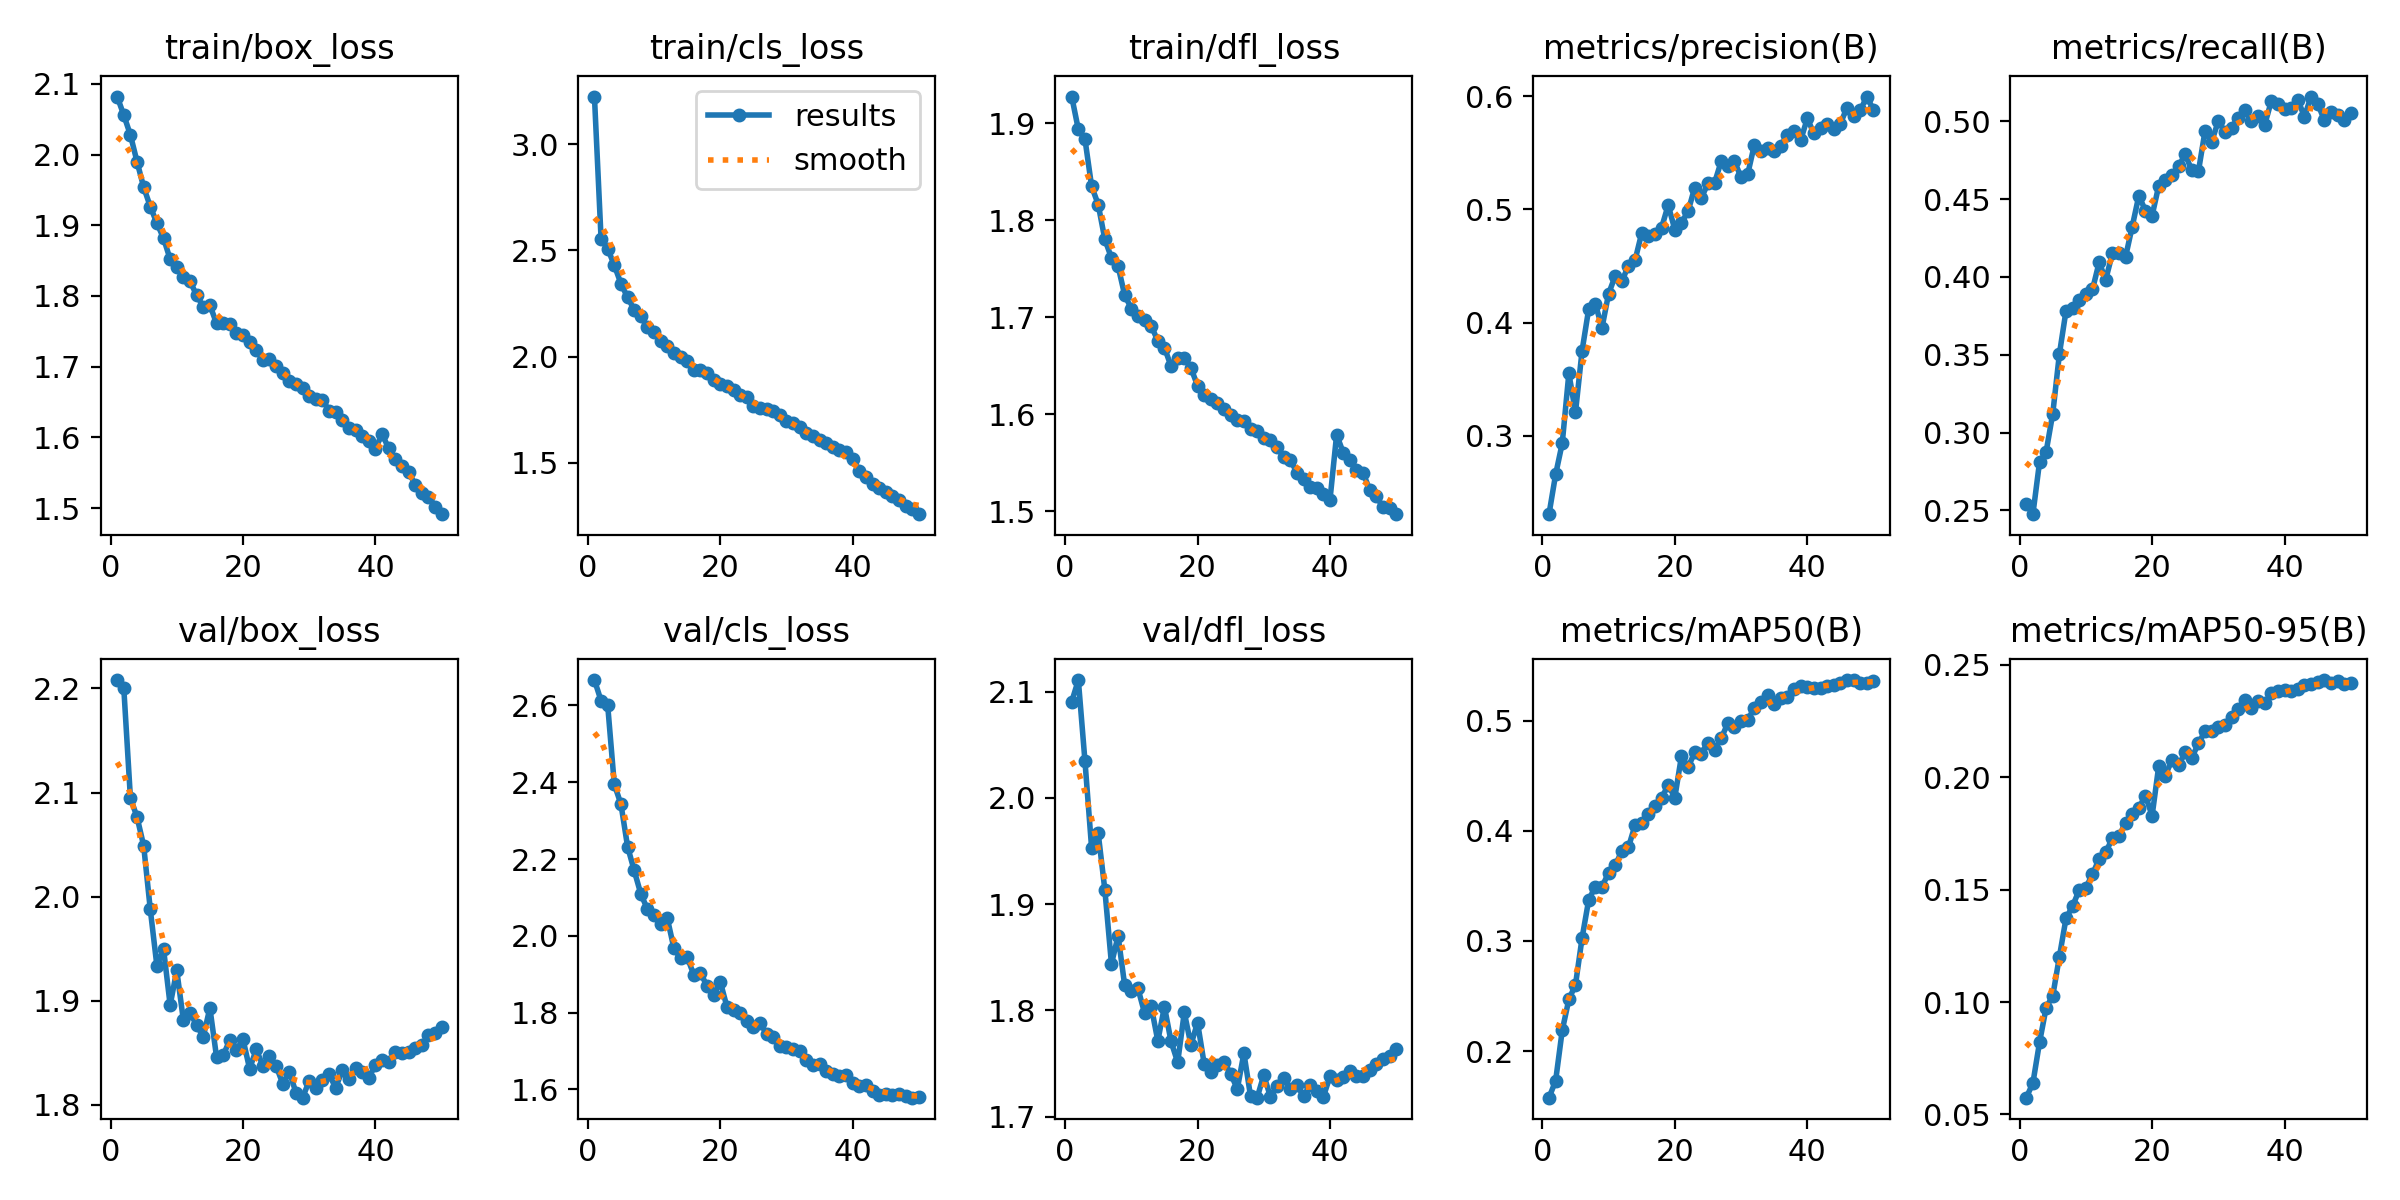


📊 Confusion Matrix:


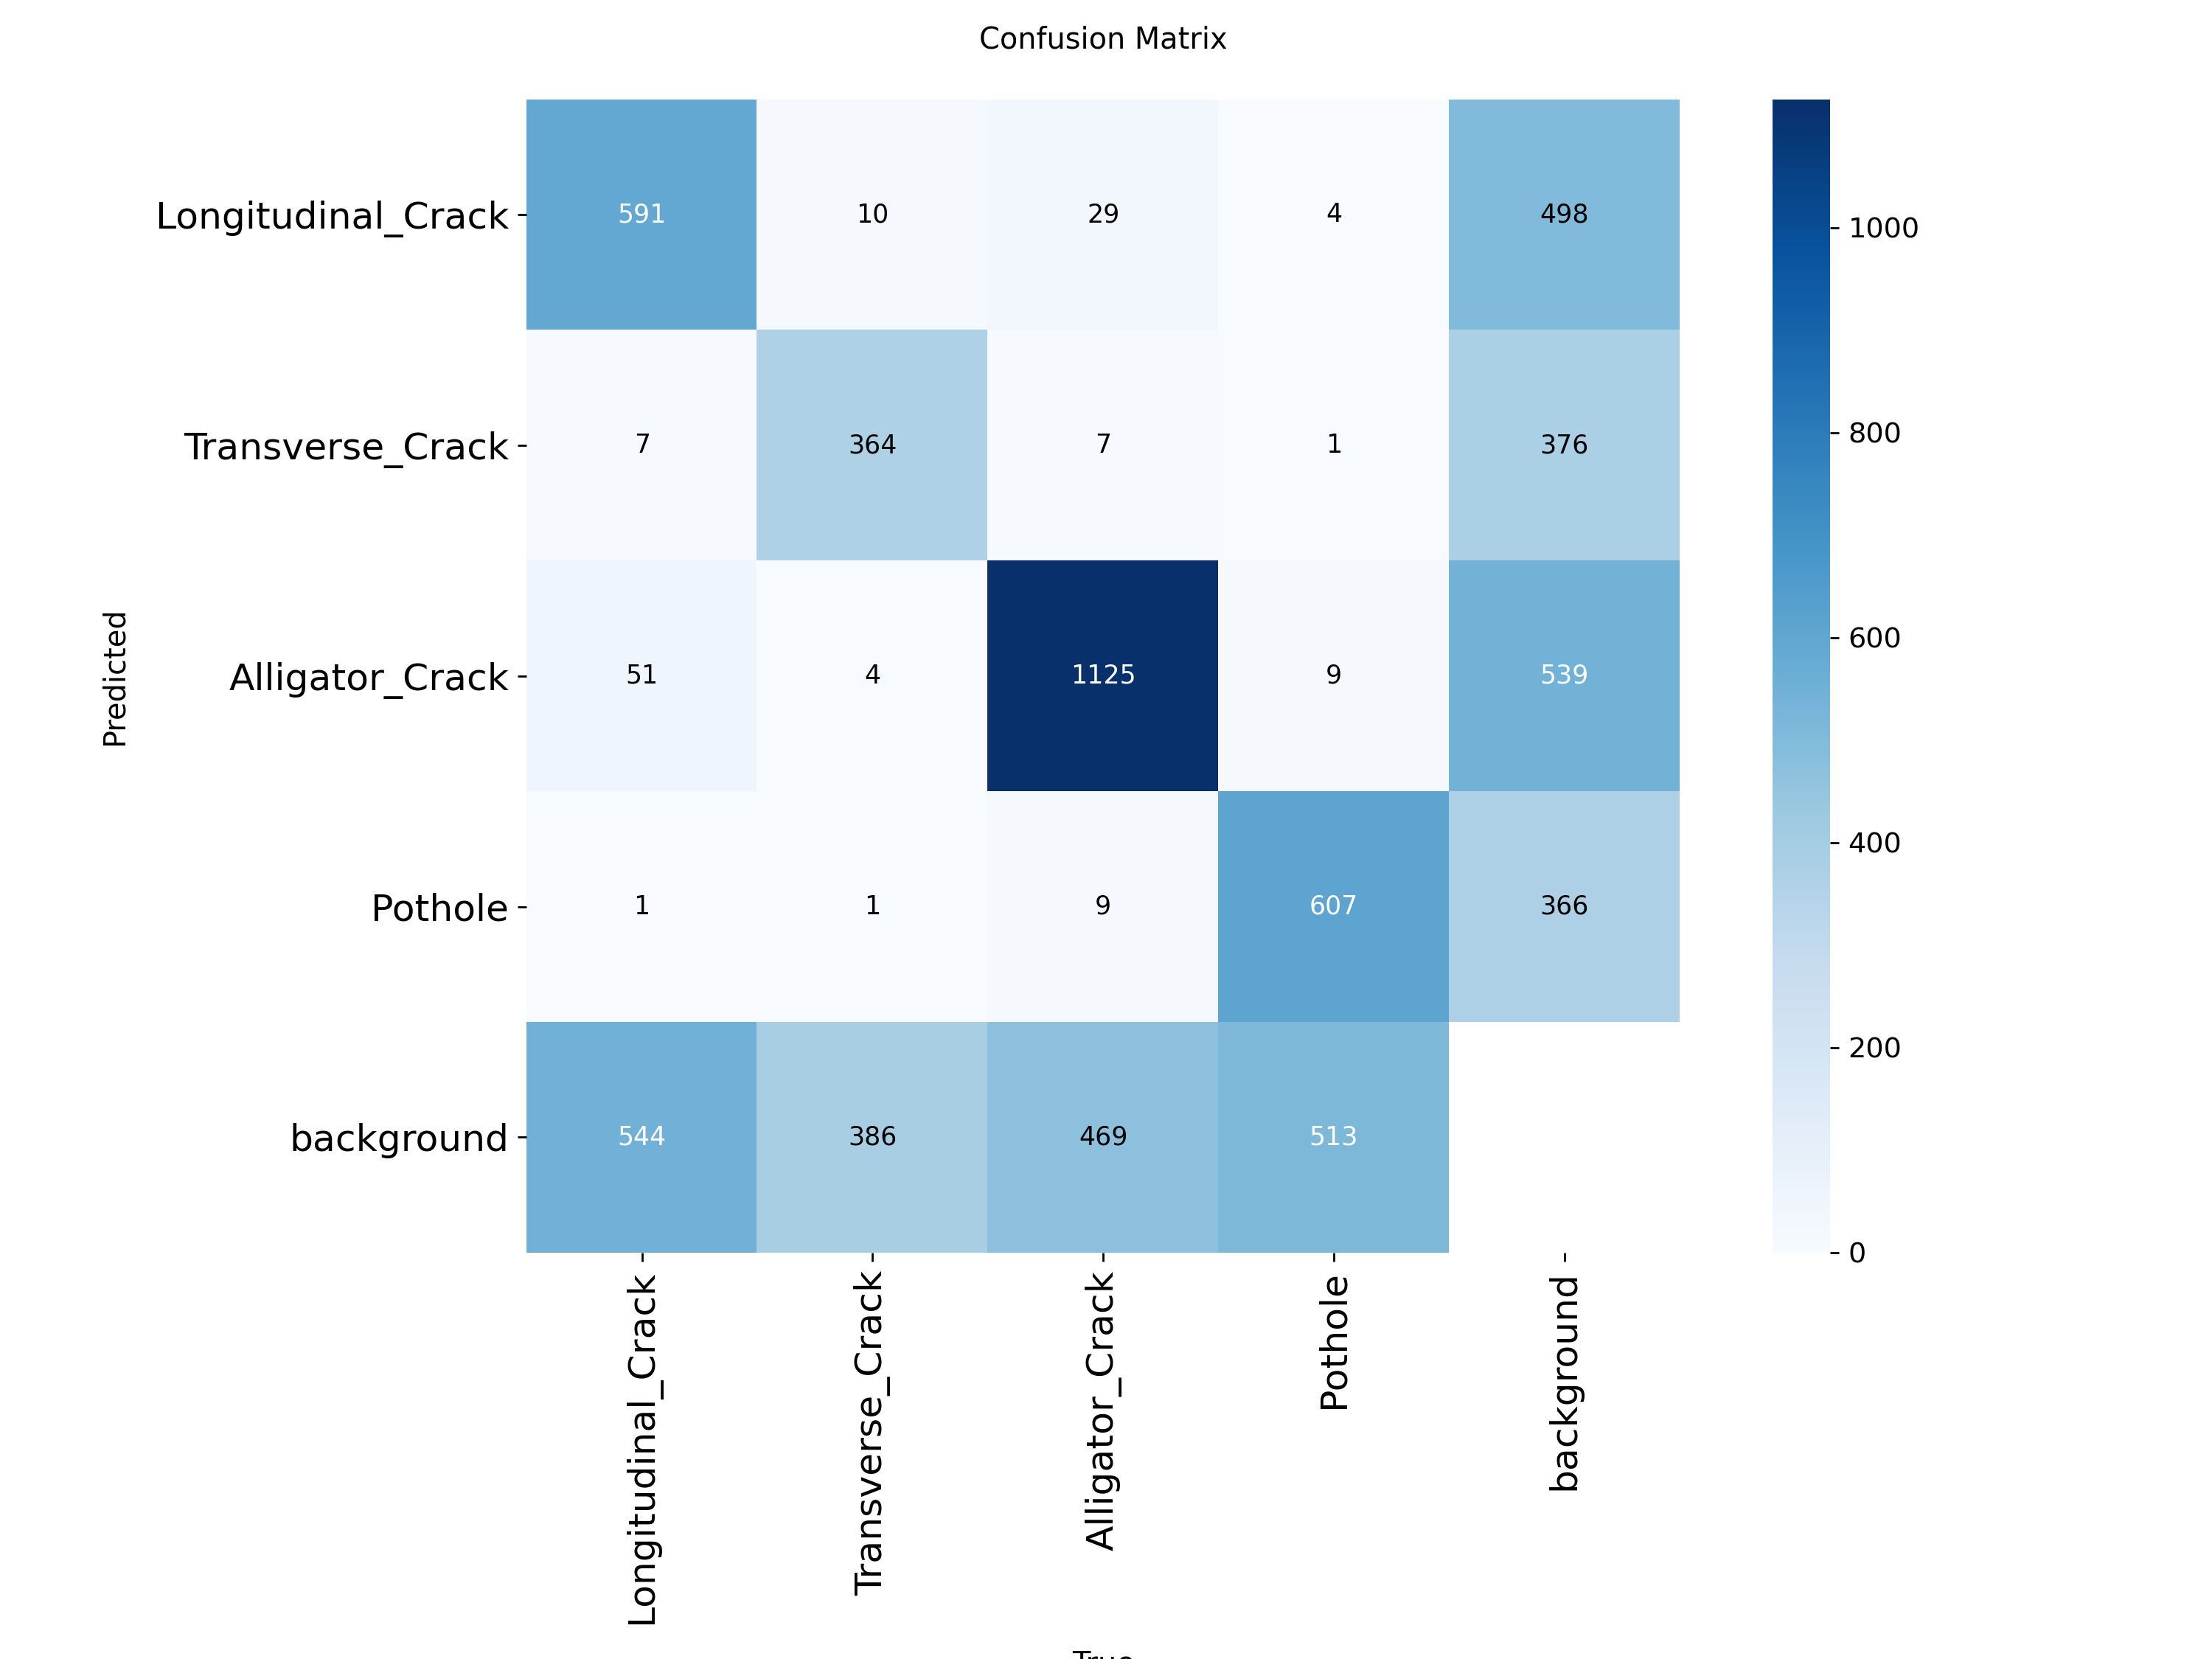


📈 PR Curve:


In [ ]:
# Tampilkan training plots
from IPython.display import Image as IPImage, display

# Training results
results_path = '/content/runs/detect/road_damage_yolov8s'

print("📈 Training Results:")
if os.path.exists(f"{results_path}/results.png"):
    display(IPImage(filename=f"{results_path}/results.png", width=800))

print("\n📊 Confusion Matrix:")
if os.path.exists(f"{results_path}/confusion_matrix.png"):
    display(IPImage(filename=f"{results_path}/confusion_matrix.png", width=600))

print("\n📈 PR Curve:")
if os.path.exists(f"{results_path}/PR_curve.png"):
    display(IPImage(filename=f"{results_path}/PR_curve.png", width=600))

## 📌 Step 8: Test Inference

In [ ]:
# Load best model
best_model_path = '/content/runs/detect/road_damage_yolov8s/weights/best.pt'
best_model = YOLO(best_model_path)

print(f"✅ Best model loaded from: {best_model_path}")

✅ Best model loaded from: /content/runs/detect/road_damage_yolov8s/weights/best.pt


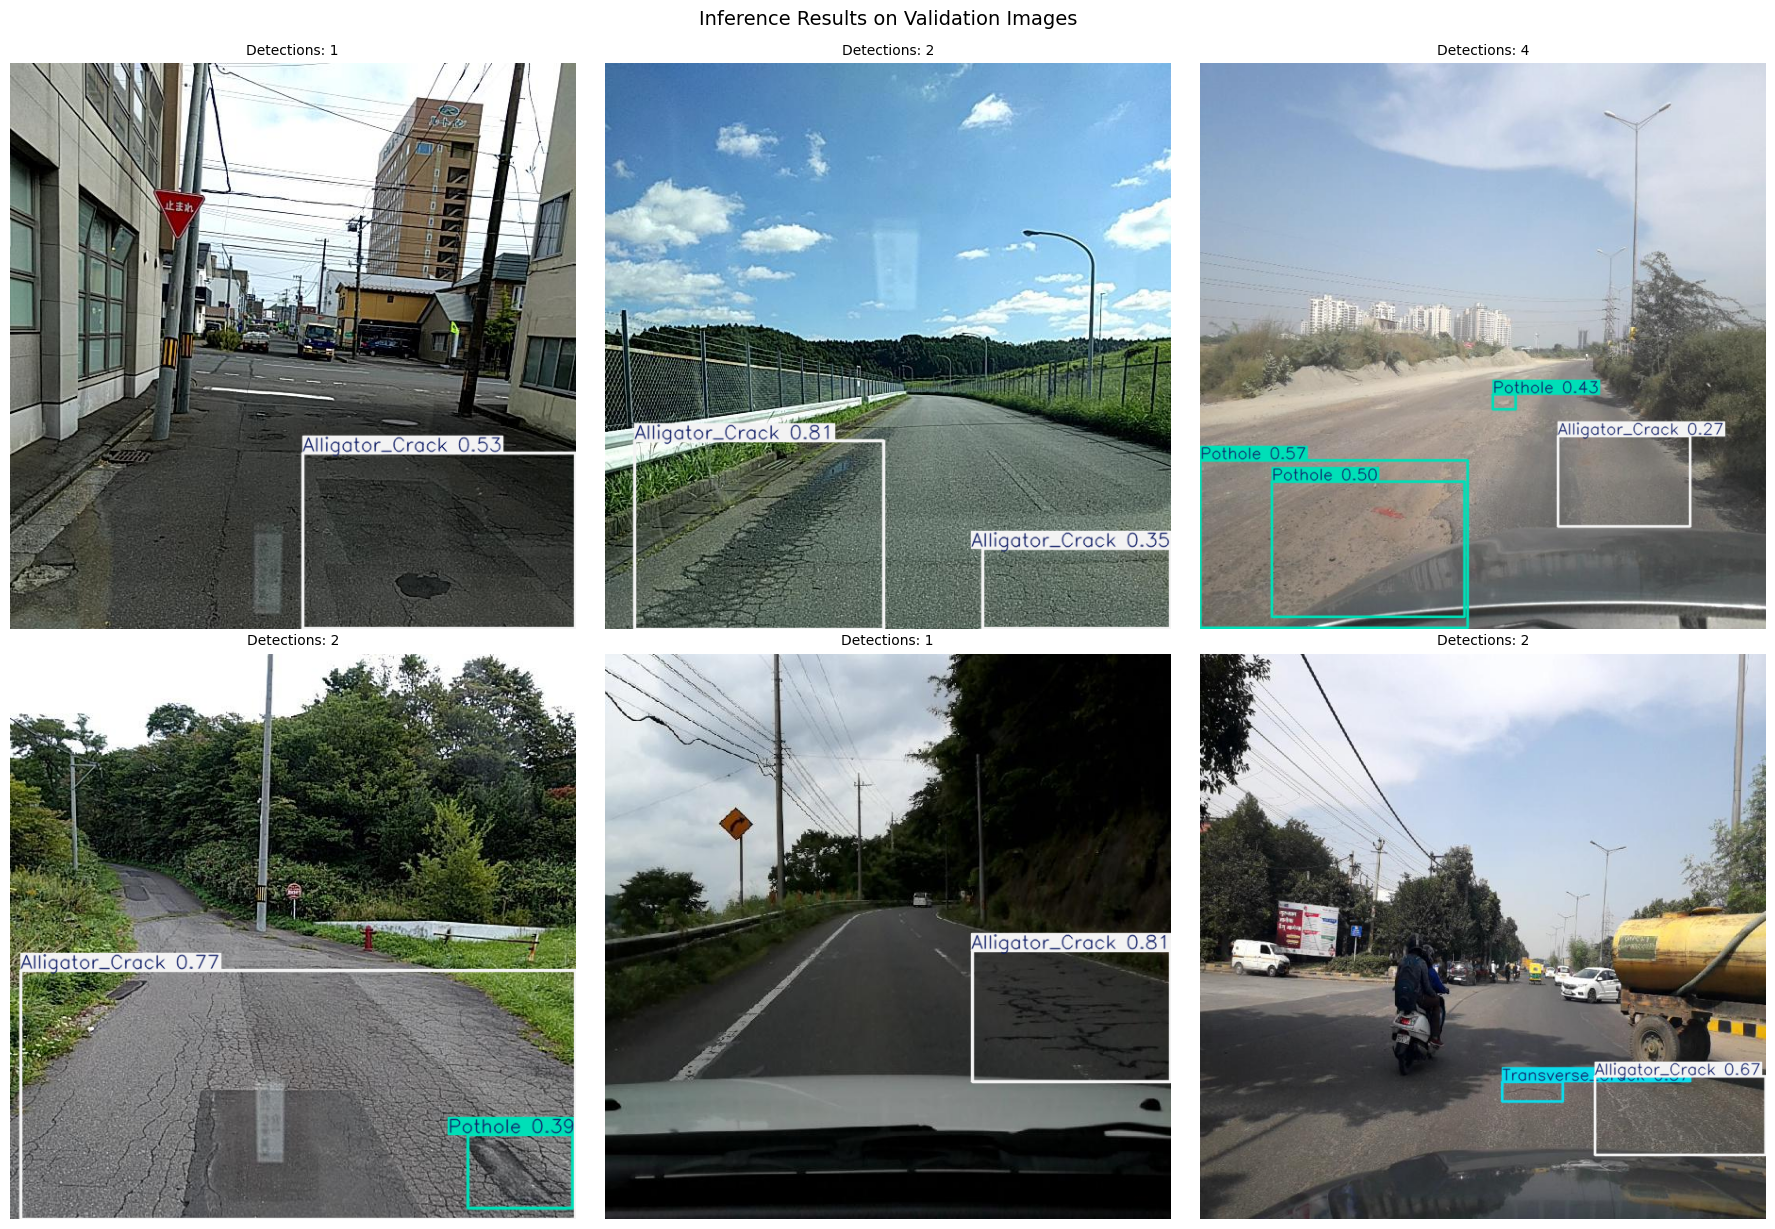

In [ ]:
# Test pada beberapa gambar validation
val_images_path = f"{OUTPUT_PATH}/images/val"
test_images = os.listdir(val_images_path)[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_name in enumerate(test_images):
    img_path = f"{val_images_path}/{img_name}"

    # Run inference
    results = best_model(img_path, verbose=False)

    # Plot results
    annotated_img = results[0].plot()
    annotated_img = annotated_img[:, :, ::-1]  # BGR to RGB

    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f"Detections: {len(results[0].boxes)}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Inference Results on Validation Images', fontsize=14, y=1.02)
plt.show()

## 📌 Step 9: Export Model & Save to Drive

In [ ]:
# Export ke format ONNX (optional, untuk deployment)
# best_model.export(format='onnx')

# Copy model ke Google Drive
import shutil

# Copy weights
weights_src = '/content/runs/detect/road_damage_yolov8s/weights/'
weights_dst = f'{SAVE_DIR}/weights/'
os.makedirs(weights_dst, exist_ok=True)

shutil.copy2(f"{weights_src}/best.pt", f"{weights_dst}/best.pt")
shutil.copy2(f"{weights_src}/last.pt", f"{weights_dst}/last.pt")

# Copy training results
results_dst = f'{SAVE_DIR}/training_results/'
if os.path.exists(results_dst):
    shutil.rmtree(results_dst)
shutil.copytree('/content/runs/detect/road_damage_yolov8s/', results_dst)

print(f"✅ Model saved to Google Drive!")
print(f"   Weights: {weights_dst}")
print(f"   Results: {results_dst}")

✅ Model saved to Google Drive!
   Weights: /content/drive/MyDrive/RoadDamageDetection/weights/
   Results: /content/drive/MyDrive/RoadDamageDetection/training_results/


## 📌 Step 10: Download Model untuk Local (VS Code)

Model yang sudah di-train bisa langsung dipakai di VS Code dengan aplikasi Streamlit

---

## 🎉 Training Selesai!

### Ringkasan:
- **Model**: YOLOv8s dengan Transfer Learning
- **Dataset**: RDD2022 (Japan + India)
- **Classes**: 4 jenis kerusakan jalan
- **Output**: Model `.pt` yang siap dipakai

### Langkah Selanjutnya:
1. Download `best.pt` dari Google Drive
2. Clone repo RoadDamageDetection
3. Jalankan aplikasi Streamlit untuk real-time detection

